In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lowEBMs.Packages.Configuration import importer, add_sellersparameters, parameterinterpolatorstepwise, reset
#from lowEBMs.Packages.Configuration import import_parallelparameter, allocate_parallelparameter, write_parallelparameter
from lowEBMs.Packages.Variables import variable_importer, Vars, reset, trackerreset, datareset
from lowEBMs.Packages.RK4 import rk4alg
from lowEBMs.Packages.ModelEquation import model_equation
#from lowEBMs.Packages.Variables import 
#from lowEBMs.Packages.Functions import plotmeanstd
from lowEBMs.Packages.Optimization import coremodule
import lowEBMs.Packages.Constants as const
from lowEBMs import update_plotstyle, moving_average
import builtins
import matplotlib
update_plotstyle()
matplotlib.rcParams['lines.linewidth']=1.1

In [2]:
time_HADCM3_str=np.genfromtxt('Data/gmt_hadcm3.csv',usecols=[0],delimiter=',',skip_header=1,dtype='str',unpack=True,encoding='ISO-8859-1')
time_HADCM3=np.zeros(len(time_HADCM3_str))
for i in range(len(time_HADCM3_str)):
    if time_HADCM3_str[i][-4]=='.':
        year=float(time_HADCM3_str[i][-3:])
    if time_HADCM3_str[i][-5]=='.':
        year=float(time_HADCM3_str[i][-4:])
    if time_HADCM3_str[i][4]=='.':
        month=(float(time_HADCM3_str[i][3:5])-1)/12
    if time_HADCM3_str[i][5]=='.':
        month=(float(time_HADCM3_str[i][3:5])-1)/12
    day=float(time_HADCM3_str[i][:2])/365
    time_HADCM3[i]=year+month+day
GMT_HADCM3=np.genfromtxt('Data/gmt_hadcm3.csv',usecols=[17],delimiter=',',skip_header=1,unpack=True,encoding='ISO-8859-1')
order=np.argsort(time_HADCM3)
GMT_HADCM3_smoothed=moving_average(GMT_HADCM3[order],12)

In [2]:
Year_volc, CWL_GMT,  EVA_GMT, CWLcorr_GMT=np.genfromtxt('Data/Volc_800_2000.txt',skip_header=1,unpack=True)
#Year_NorESM, SO4_FORC, SAT_GISS, SAT_VOLC, SAT_ZERO, SAT_AFIT, SAT_TREN= \
#np.genfromtxt('Data/NorESM_Pinatubo_GMST_response.txt',skip_header=1,unpack=True)
Year_volc_1800_1850=Year_volc[int(1000*365/4):int(1040*365/4)]
Year_volc_1808_1858=Year_volc[int(1008*365/4):int(1048*365/4)]
EVA_GMT_1800_1850=EVA_GMT[int(1000*365/4):int(1040*365/4)]
EVA_GMT_1808_1858=EVA_GMT[int(1008*365/4):int(1048*365/4)]
Lat_10,ZMT_10=np.loadtxt('Data/ERA_ZMT_Mean_10deginterpolated.txt')
Year_NorESM, SO4_FORC, SAT_GISS, SAT_VOLC, SAT_ZERO, SAT_AFIT, SAT_TREN= \
np.genfromtxt('Data/NorESM_Pinatubo_GMST_response.txt',skip_header=1,unpack=True)
NORESM_1990_2005=SAT_VOLC-SAT_TREN

In [3]:
def coremodule(config,P0,P_pert_ratio,Pmin,Pmax,labels,ZMT,GMT,grid,maxlength,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_paras,gamma0,control,controlconfig):
    from tqdm import tqdm, tnrange
    
    F=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,2*num_paras+1))
    dF=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    P=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    Ptrans=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    gamma=np.zeros(maxlength)
    
    if targetmode=='Single':
        dataout=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,(2*num_paras+1)))
    elif targetmode=='ZMT':
        dataout=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
    elif targetmode=='GMT':
        dataout=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))
    elif targetmode=='Coupled':
        dataout_ZMT=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
        dataout_GMT=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))     
    for i in tnrange(maxlength):
        print('Iteration no.'+str(i))
        if i==0:
            P[i]=P0
            P_pert=(Pmax-Pmin)*P_pert_ratio
            Ptrans[i]=(P0-Pmin)/(Pmax-Pmin)
            Ptrans_pert=Ptrans[i]*P_pert_ratio

        if targetmode=='Coupled':
            data_ZMT,data_GMT=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout_ZMT[i]=data_ZMT
            dataout_GMT[i]=data_GMT
        else:
            data=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout[i]=data
            
        if targetmode=='Coupled':
            target_ZMT=target['ZMT']
            target_GMT=target['GMT']
            F_ZMT=target_comparison(data_ZMT,'ZMT',target_ZMT,targetfunction,num_paras,grid)
            F_GMT=target_comparison(data_GMT,'GMT',target_GMT,targetfunction,num_paras,grid)
            F[i]=ratio_ZMT_GMT*F_ZMT+(1-ratio_ZMT_GMT)*F_GMT
        else:
            F[i]=target_comparison(data,targetmode,target,targetfunction,num_paras,grid)

        dF[i]=local_gradient(F[i],Ptrans_pert)
        #dF[i]=local_gradient(F[i],P_pert)
        if i==0:
            gamma[i]=gamma0
        else:
            #gamma[i]=step_weighting(dF[i-1],dF[i],P[i-1],P[i])
            gamma[i]=step_weighting(dF[i-1],dF[i],Ptrans[i-1],Ptrans[i])
            
        if precision_check(dF[0],dF[i],precision):
            print('stop',i)
            P=P[:i]
            Ptrans=Ptrans[:i]
            F=F[:i]
            dF=dF[:i]
            gamma=gamma[:i]
            break
                
        #P_next=new_parameters(P[i],gamma[i],dF[i])        
        Ptrans_next=new_parameters(Ptrans[i],gamma[i],dF[i])

        for k in range(num_paras):
            if Ptrans_next[k]<0:
                Ptrans_next[k]=0.
            if Ptrans_next[k]>1:
                Ptrans_next[k]=1.

        if i<maxlength-1:
            Ptrans[i+1]=Ptrans_next
            P[i+1]=Pmin+Ptrans_next*(Pmax-Pmin)
            print(F[i])
            print(gamma[i])
            print(P[i+1])
            
        if targetmode=='Coupled':
            dataout=[dataout_ZMT,dataout_GMT]
            
    return F, dF, P , Ptrans, gamma, dataout
    
def target_comparison(data,targetmode,target,targetfunction,num_paras,grid):
    F=np.zeros(2*num_paras+1)
    if targetfunction=='LeastSquare':
        if targetmode=='Single':
            F=(np.array(data)-target)**2
        elif targetmode=='ZMT':
            for i in range(len(F)):
                if len(data[i])==len(target):
                    F[i]=np.sum(((data[i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
                elif len(data[i])==len(F):
                    F[i]=np.sum(((data[:,i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
        elif targetmode=='GMT':
            for i in range(len(F)):
                F[i]=np.sum((data[i]-target)**2)

    return F

def local_gradient(F,P_pert):
    dF=np.zeros(len(P_pert))
    for k in range(len(P_pert)):
        dF[k]=(F[2*(k+1)-1]-F[2*(k+1)])/(2*P_pert[k])
    return dF

def step_weighting(dF0,dF1,P0,P1):
    gamma=np.abs(np.dot(P1-P0,dF1-dF0)/np.dot(np.abs(dF1-dF0),np.abs(dF1-dF0)))
    return gamma

def precision_check(dF0,dF,precision):
    dFabs=np.sqrt(np.dot(dF,dF))
    dF0abs=np.sqrt(np.dot(dF0,dF0))
    if dFabs/dF0abs <= precision:
        return True
    
def new_parameters(P,gamma,dF):
    P_next=P-gamma*dF
    return P_next

def run_model(config,P,P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation):
    
    P_config=reshape_parameters(P,P_pert)
    setup={'number_of_parameters': len(P), 'number_of_cycles': 1, 'number_of_parallels': len(P)*2+1}
    
    if targetmode=='Coupled':
        control=True
        
    if control==True:
        variable_importer(controlconfig,initialZMT=True,parallel=True,parallel_config=setup)
        controlconfig=add_parameters(controlconfig,P_config,labels)
        data_CTRL=rk4alg(model_equation,controlconfig['eqparam'],controlconfig['rk4input'],controlconfig['funccomp'],progressbar=True)
        ZMT,GMT=data_CTRL[1][-1],data_CTRL[2][-1]

    variable_importer(config,initialZMT=False,parallel=True,parallel_config=setup)
    config=add_parameters(config,P_config,labels)
    Vars.T,Vars.T_global=ZMT,GMT   
    data=rk4alg(model_equation,config['eqparam'],config['rk4input'],config['funccomp'],progressbar=True)
    
    if targetmode=='Single':
        data_out=data[2][-1]
    elif targetmode=='ZMT':
        dataZMT=data[1][-1]
        for i in range(len(dataZMT)):
            dataZMT[i]=dataZMT[i]+elevation
        data_out=dataZMT
    elif targetmode=='GMT':
        data_out=np.transpose(data[2][:-1]-data[2][0])
    elif targetmode=='Coupled':
        dataZMT=data_CTRL[1][-1]
        for i in range(len(dataZMT)):
            dataZMT[i]=dataZMT[i]+elevation
        dataGMT=np.transpose(data[2][:-1]-data[2][0])
        data_out=[dataZMT,dataGMT]
    return data_out

def reshape_parameters(P,P_pert):
    num_para=len(P)
    P_config=np.reshape(np.zeros(num_para*(2*num_para+1)),(num_para,2*num_para+1))
    for i in range(num_para):
        P_config[i]=np.array([P[i]]*(2*num_para+1))
        P_config[i][i*2+1]=P[i]+P_pert[i]
        P_config[i][i*2+2]=P[i]-P_pert[i]
                      
    return P_config
             
def add_parameters(config,P_config,labels):
    num_para=len(P_config)
    
    for i in range(num_para):
        if labels[i][0][:4]=='func':
            config['funccomp']['funcparam'][labels[i][0]][labels[i][1]]=P_config[i]
        if labels[i][0]=='eqparam':
            config[labels[i][0]][labels[i][1]]=P_config[i]
    return config

In [ ]:
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b']]
#labels=[['eqparam','c_ao'],['func1','m'],['func1','gamma'],['func3','f'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#P0=np.array([70*4.2e6,230,2.5])
#P0=np.array([50*4.2e6,0.5,1.9e-15,0,1.165,1.165,1.165])
#Pmin=np.array([0.5*10*4.2e6,0.4,0.6e-15,-50,0.9,0.9,0.9])
#Pmax=np.array([100*4.2e6,0.6,5e-15,50,1.2,1.2,1.2])
#P_pert_ralative=[1/10000,1/10000,1/10000,1/10000,1/10000,1/10000]
#labels=[['func3','f1'],['func3','f2'],['func3','f3'],['func3','f4'],['func3','f5'],['func3','f6'],['func3','f7'],['func3','f8'],['func3','f9'],['func3','f10'],\
#       ['func3','f11'],['func3','f12'],['func3','f13'],['func3','f14'],['func3','f15'],['func3','f16'],['func3','f17'],['func3','f18']]
#P0=np.zeros(18)
"""labels=[['eqparam','c_ao'],['func1','k'],['func1','m'],['func1','gamma'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
P0=np.array([70*4.2e6,1,0.5,1.9e-15,1.165,1.165,1.165])
P0=np.array([3.7081e+08, 9.8089e-01, 4.8458e-01, 5.0000e-15, 1.1702e+00, 1.1674e+00, 1.1998e+00])
Pmin=np.array([1*4.2e6,0.9,0.4,0.5e-15,0.9,0.9,0.9])
Pmax=np.array([150*4.2e6,1.1,0.6,5e-15,1.3,1.3,1.3])"""

labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
P0=np.array([70*4.2e6,230,2.5,1.165,1.165,1.165])
Pmin=np.array([1*4.2e6,190,1.9,0.9,0.9,0.9])
Pmax=np.array([150*4.2e6,250,3.3,1.3,1.3,1.3])
#Pmax=np.full(18,50)
#Pmin=np.full(18,-50)
#print(Pmax)
P_pert_ratio=1/10000
#Pmin=np.array([20*4.2e6,190,1.7])
#Pmax=np.array([120*4.2e6,250,3.3])
#P_pert=(Pmax-Pmin)/100
precision=1e-5
maxlength=int(100)
targetmode='Coupled'
target={'GMT':NORESM_1990_2005,'ZMT':ZMT_10}
targetfunction='LeastSquare'
ratio_ZMT_GMT=0.1
num_params=6
gamma0=1e-8
setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': int(num_params*2+1)}
control=True

config_CTRL=importer('Dev_Data/Optimization/Volcanic_Budyko_CTRL.ini')
#print(config_CTRL)
variable_importer(config_CTRL,initialZMT=True,parallel=False)
config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
        
config_base=importer('Dev_Data/Optimization/Volcanic_Budyko.ini')
variable_importer(config_base,initialZMT=True,parallel=True,parallel_config=setup)

config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)

elevation=-0.0065*np.array(ParasCTRL[1][1])
Zero_ZMT,Zero_GMT=Vars.T,Vars.T_global
grid=Vars.Lat

F, dF, P, Ptrans , gamma, data=coremodule(config_base,P0,P_pert_ratio,Pmin,Pmax,labels,Zero_ZMT,Zero_GMT,grid,maxlength\
        ,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_params,gamma0,control,config_CTRL)

Loading Configuration from: Dev_Data/Optimization/Volcanic_Budyko_CTRL.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini
Loading Configuration from: Dev_Data/Optimization/Volcanic_Budyko.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Iteration no.0


[17888.18999508 17888.1898724  17888.19011789 17889.14106855
 17887.23894713 17886.6077993  17889.77243915 17888.19064922
 17888.18934094 17888.19039401 17888.18959615 17888.19295096
 17888.18703911]
1e-08
[2.94000017e+08 2.29991440e+02 2.50051689e+00 1.16499996e+00
 1.16499998e+00 1.16499982e+00]
Iteration no.1


[17880.99337678 17880.99325416 17880.99349953 17881.94406046
 17880.04271862 17879.41223375 17882.57476789 17880.99403072
 17880.99272285 17880.99377551 17880.99297806 17880.99633175
 17880.99042173]
1.5531209417215246e-05
[2.94025766e+08 2.16702878e+02 3.30000000e+00 1.16493864e+00
 1.16496259e+00 1.16472272e+00]
Iteration no.2


[4002.92108031 4002.57494793 4003.26703769 4008.08262964 3997.75972029
 4000.56407539 4005.28016333 4002.94202092 4002.90010367 4002.92948619
 4002.91263856 4003.02271994 4002.81929405]
5.562223848129566e-06
[3.20036561e+08 1.90864629e+02 3.30000000e+00 1.16423478e+00
 1.16467969e+00 1.16130687e+00]
Iteration no.3


[35.39137754 35.39129021 35.39146495 35.42698157 35.35580048 35.40254574
 35.38021033 35.39152787 35.3912272  35.39142778 35.39132729 35.39218661
 35.3905685 ]
3.704274007547896e-06
[3.20040935e+08 1.90745975e+02 3.29864864e+00 1.16423142e+00
 1.16467856e+00 1.16128878e+00]
Iteration no.4


[34.58567521 34.58558773 34.58576279 34.62069576 34.55068167 34.59673161
 34.57461983 34.58582671 34.58552371 34.58572568 34.58562473 34.58648829
 34.58486216]
0.00023764715799896603
[3.20322035e+08 1.90000000e+02 3.21282021e+00 1.16401404e+00
 1.16460614e+00 1.16012215e+00]
Iteration no.5


[24.29905648 24.29895787 24.29915519 24.32700106 24.27114101 24.30859259
 24.28952195 24.29921329 24.29889967 24.29910722 24.29900574 24.29987784
 24.29823516]
0.00027893374603307216
[3.20693936e+08 1.90000000e+02 3.12593595e+00 1.16374995e+00
 1.16452069e+00 1.15873890e+00]
Iteration no.6


[18.68215895 18.6820471  18.68227091 18.70566942 18.65867999 18.69058213
 18.67373781 18.68231529 18.68200261 18.68220877 18.68210913 18.68296779
 18.68135017]
0.0003161036229208225
[3.21171947e+08 1.90000000e+02 3.03896830e+00 1.16345157e+00
 1.16442560e+00 1.15719525e+00]
Iteration no.7


[13.8445982  13.84447076 13.84472575 13.86286166 13.82636895 13.85158443
 13.83761459 13.84475668 13.84443972 13.84464774 13.84454866 13.84540471
 13.84379174]
0.00028447888681851186
[3.21662080e+08 1.90000000e+02 2.97405761e+00 1.16317936e+00
 1.16434050e+00 1.15581002e+00]
Iteration no.8


[10.87568502 10.87554425 10.8758259  10.88940884 10.86199767 10.88133607
 10.87003714 10.87584727 10.87552278 10.8757349  10.87563514 10.87649851
 10.87487159]
0.00025740737513162165
[3.22151935e+08 1.90000000e+02 2.92655328e+00 1.16292721e+00
 1.16426298e+00 1.15454578e+00]
Iteration no.9


[9.12104632 9.12089485 9.1211979  9.1310589  9.111072   9.12554865
 9.11654761 9.12121274 9.1208799  9.1210968  9.12099584 9.12187067
 9.12022203]
0.0002379825814605524
[3.22639244e+08 1.90000000e+02 2.89156580e+00 1.16268808e+00
 1.16419045e+00 1.15336134e+00]
Iteration no.10


[8.0864889  8.08632908 8.08664883 8.093535   8.06351174 8.09003858
 8.0802943  8.08665925 8.08631854 8.08654004 8.08643775 8.08732477
 8.08565308]
3.786516638498958e-05
[3.22721053e+08 1.90000000e+02 2.88553932e+00 1.16264913e+00
 1.16417876e+00 1.15317025e+00]
Iteration no.11


[7.86385812 7.86370491 7.86401144 7.87291976 7.85484834 7.86795703
 7.85977285 7.86400835 7.86370789 7.86390301 7.86381322 7.86456112
 7.86316469]
9.48447927883169e-06
[3.22740697e+08 1.90000000e+02 2.88427148e+00 1.16264053e+00
 1.16417619e+00 1.15313026e+00]
Iteration no.12


[7.82619245 7.82604435 7.82634541 7.83514079 7.81730349 7.83025376
 7.82214482 7.82635246 7.82604193 7.82624216 7.82614748 7.8268969
 7.82549761]
0.0002051182168736738
[3.23157949e+08 1.90000000e+02 2.85710439e+00 1.16244824e+00
 1.16411756e+00 1.15226379e+00]
Iteration no.13


[7.13920306 7.13906304 7.13933658 7.14431842 7.13414087 7.14210019
 7.13631062 7.13937364 7.13903433 7.13925503 7.13915452 7.13999665
 7.13840643]
0.00012939073269276652
[3.23397100e+08 1.90000000e+02 2.84486883e+00 1.16231570e+00
 1.16407829e+00 1.15164263e+00]
Iteration no.14


[6.89586725 6.89573502 6.8959996  6.89920928 6.89260883 6.89821006
 6.89353585 6.89604162 6.89569289 6.89591749 6.89581702 6.89670537
 6.89503017]
0.00012674741840276762
[3.23623683e+08 1.90000000e+02 2.83519224e+00 1.16218226e+00
 1.16403985e+00 1.15100164e+00]
Iteration no.15


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

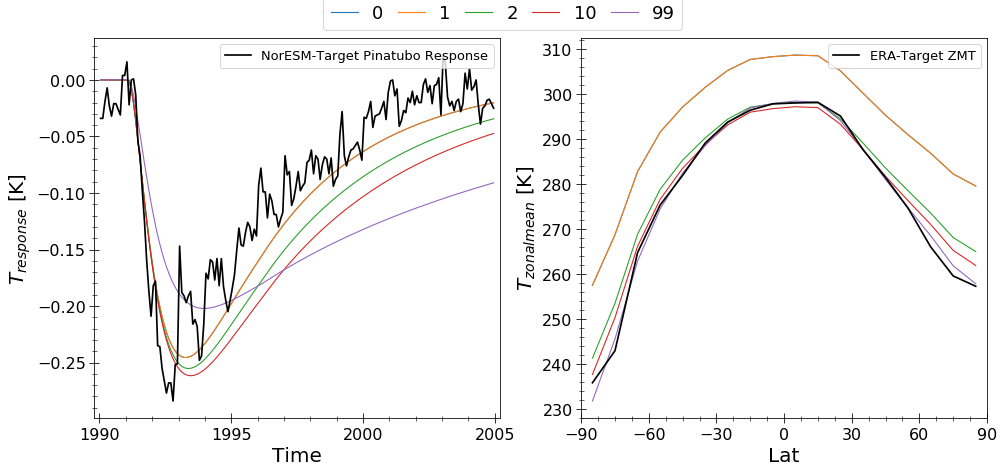

In [98]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
for i in [0,1,2,10,99]:
    ax[0].plot(Year_NorESM,data[1][i,0],label=i)
plt.figlegend(fontsize=18,ncol=5,bbox_to_anchor=(0.6,0.96),columnspacing=0.8,handlelength=1.5)
for i in [0,1,2,10,99]:
    ax[1].plot(Vars.Lat,data[0][i,0])
#plt.plot(Year_volc_1808_1858,data[1,1])
#plt.plot(Year_volc_1808_1858,data[1,2])
#plt.plot(Year_volc_1808_1858,data[1,3])
#plt.plot(Year_volc_1808_1858,data[1,4])
line1=ax[0].plot(Year_NorESM,NORESM_1990_2005,c='k',linewidth=1.7,label='NorESM-Target Pinatubo Response')
line2=ax[1].plot(Lat_10,ZMT_10,c='k',linewidth=1.7,label='ERA-Target ZMT')
ax[1].set_xticks(np.linspace(-90,90,7)), ax[1].set_xlim(-90,90)
ax[0].set_xlabel('Time'),ax[0].set_ylabel('$T_{response}$ [K]')
ax[1].set_xlabel('Lat'),ax[1].set_ylabel('$T_{zonal mean}$ [K]')
ax[0].set_xticks(np.linspace(1990,2005,4)), ax[0].set_xlim(1989.8,2005.2)
ax[0].legend((line1),['NorESM-Target Pinatubo Response'],fontsize=13,loc='upper right')
ax[1].legend((line2),['ERA-Target ZMT'],fontsize=13,loc='upper right')
#plt.figlegend(fontsize=18,ncol=5,bbox_to_anchor=(0.6,0.96),columnspacing=0.8,handlelength=1.5)
#plt.xlim(1808,1858)
plt.savefig('Data/Coupled_Optimization_SellersRup_025.eps',format='EPS',bbox_inches='tight')

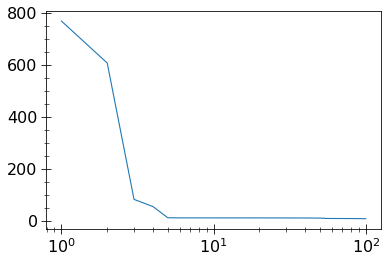

In [30]:
plt.plot(np.arange(100)+1,F[:,0])
plt.xscale('log')
#plt.yscale('log')

In [31]:
print(gamma)
print(F)
print(dF)
print(P)

[1.00000000e-07 9.99972776e-08 7.96411807e-05 1.25390005e-04
 1.12720129e-04 1.10334142e-04 1.14971662e-04 1.10323682e-03]
[[4908.46279504 4907.68081928 4909.23973105 4895.28385247 4923.48298139
  4823.27040287 5054.43158254 4908.28522758 4908.63776618 4908.43195343
  4908.4941851  4907.80603045 4909.1303077 ]
 [1753.97298698 1753.97300141 1753.97298094 1754.48947943 1753.45663279
  1753.97427467 1753.97169816 1753.9730001  1753.97298007 1753.97303131
  1753.97294266 1753.97350971 1753.97247316]
 [1751.16403766 1751.16404821 1751.16402823 1751.67986844 1750.64831832
  1751.16532353 1751.16274737 1751.16404375 1751.16403319 1751.16407915
  1751.1639929  1751.16454727 1751.16352985]
 [ 276.06893623  276.0685077   276.0693672   276.25742215  275.88053744
   276.07116675  276.06670406  276.07005415  276.06781831  276.06927555
   276.0685969   276.07429964  276.06357283]
 [  90.3567686    90.35446318   90.35907689   90.33866833   90.37496561
    90.35391603   90.35962299   90.35721128   90.

In [18]:
print(70*4.2e6)

294000000.0


In [30]:
print(0.33*np.sum(((data[0][8,0]-target['ZMT'])*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2))
print(0.66*np.sum(((data[1][8,0]-target['GMT']))**2))

38.13576100244077
45.9309035943473


In [35]:
print(np.sqrt(np.dot(dF[-2],dF[-2])))
print(np.sqrt(np.dot(dF[0],dF[0])))

117.79102151319456
7220029.930903146


In [10]:
#setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': int(num_params*2+1)}
#labels=[['eqparam','c_ao'],['func1','m'],['func1','gamma'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#P=[3.02794273e+08, 4.80868504e-01, 2.47299528e-15, 1.16506701e+00, 1.16500290e+00, 1.16499030e+00]
#P1=[2.10056979e+08, 5.00042362e-01, 2.01124229e-15, 1.16500050e+00,1.16500009e+00, 1.16500191e+00]
P=[ -7.09368689, -24.3554691,  -36.65052905, -47.96235225, -49.82912432,
   -49.07644568, -46.95244629, -45.62632961, -44.43208399, -43.93356111,
 -43.94788769, -42.54654785, -40.14638466, -31.07944123, -38.64653433,
 -31.9551132 , -20.29119435,  -5.61999035]
labels=[['func3','f1'],['func3','f2'],['func3','f3'],['func3','f4'],['func3','f5'],['func3','f6'],['func3','f7'],['func3','f8'],['func3','f9'],['func3','f10'],\
       ['func3','f11'],['func3','f12'],['func3','f13'],['func3','f14'],['func3','f15'],['func3','f16'],['func3','f17'],['func3','f18']]
config_CTRL=importer('Dev_Data/Optimization/Volcanic_Sellers_CTRL_Offset.ini')
variable_importer(config_CTRL,initialZMT=True,parallel=False)
config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
config_CTRL=add_parameters(config_CTRL,P,labels)
data_CTRL=rk4alg(model_equation,config_CTRL['eqparam'],config_CTRL['rk4input'],config_CTRL['funccomp'],progressbar=True)
ZMT,GMT=data_CTRL[1][-1],data_CTRL[2][-1]

config_base=importer('Dev_Data/Optimization/Volcanic_Sellers_Offset.ini')
variable_importer(config_base,initialZMT=False)
config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
config=add_parameters(config_base,P,labels)
Vars.T,Vars.T_global=ZMT,GMT   
data1=rk4alg(model_equation,config['eqparam'],config['rk4input'],config['funccomp'],progressbar=True)

Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers_CTRL_Offset.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini



Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers_Offset.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


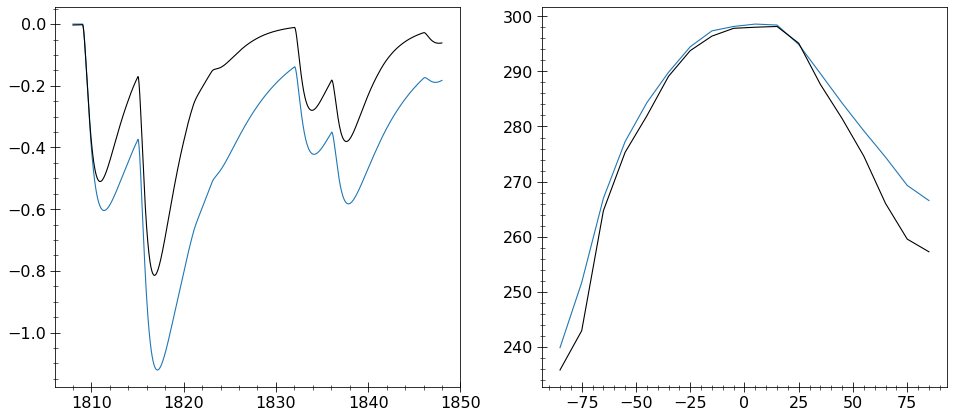

In [12]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
#ax[0].plot(data[0]/constants.time_sec_year,data[2]-data[2][0])
ax[0].plot(data1[0]/const.time_sec_year,data1[2]-data1[2][0])
ax[0].plot(Year_volc_1808_1858,EVA_GMT_1808_1858,c='k')

elevation=-0.0065*np.array(ParasCTRL[1][1])
#ax[1].plot(Vars.Lat,data[1][0]+elevation)
ax[1].plot(Vars.Lat,data1[1][0]+elevation)
ax[1].plot(Lat_10,ZMT_10,c='k')

#plt.savefig('Coupled_Optimization.eps',format='EPS')

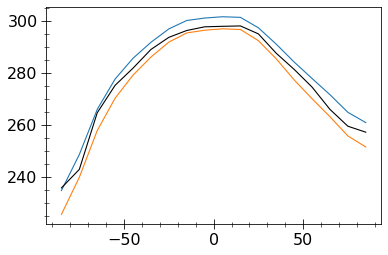

In [25]:
elevation=-0.0065*np.array(ParasCTRL[1][1])
plt.plot(Vars.Lat,data[1][0]+elevation)
plt.plot(Vars.Lat,data1[1][0]+elevation)
plt.plot(Lat_10,ZMT_10,c='k')